In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [3]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from np_utils import curved_data, planck_des_data
from torch_utils import TrainUtil
from tension_net import TensionNet1, TensionNet2
from tension_quantify import BayesFactor, SuspiciousnessKLDiv

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
X1, X1_weights, X0, X0_weights, X_prior, params = planck_des_data()
weights = { "XA": X0_weights, "XB": X1_weights }

X0 = X0[:, :7]
X1 = X1[:, :7]
X_prior = X_prior[:, :7]

In [6]:
tension_R = TensionNet2(7, hidden_size=(128, 64))
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50)
optimizer = optim.SGD(tension_R.parameters(), lr=0.00005)

train_util_R = TrainUtil(tension_R, optimizer, criterion, device,  
                         animation=False)
losses_R = train_util_R.train(X0, X1, X_prior, weights=weights, n_iter=2000)

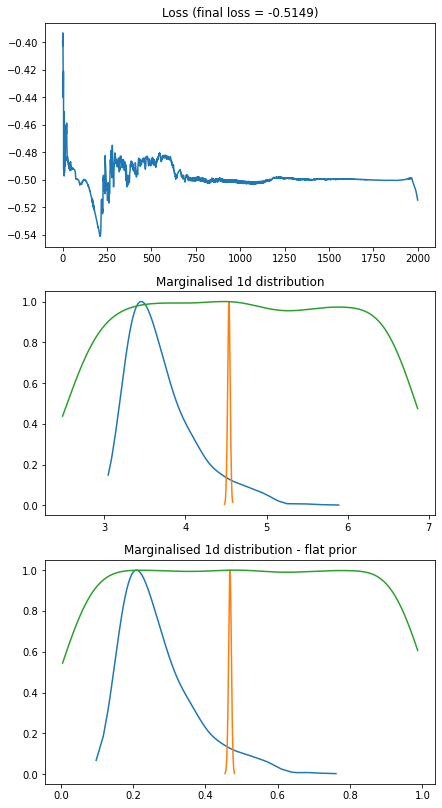

In [7]:
from anesthetic.plot import kde_contour_plot_2d

fig, axs = plt.subplots(3, 1, figsize=(7, 14))


train_util_R.plot_loss(axs[0])
# train_util_R.visualise_coordinate(axs[1, 0], idxs=(0, 1))
# train_util_R.visualise_tension(axs[2, 0], idxs=(0, 1))
train_util_R.plot_marginalised_dists(axs[1])
train_util_R.plot_marginalised_dists(axs[2], flat_prior=True)

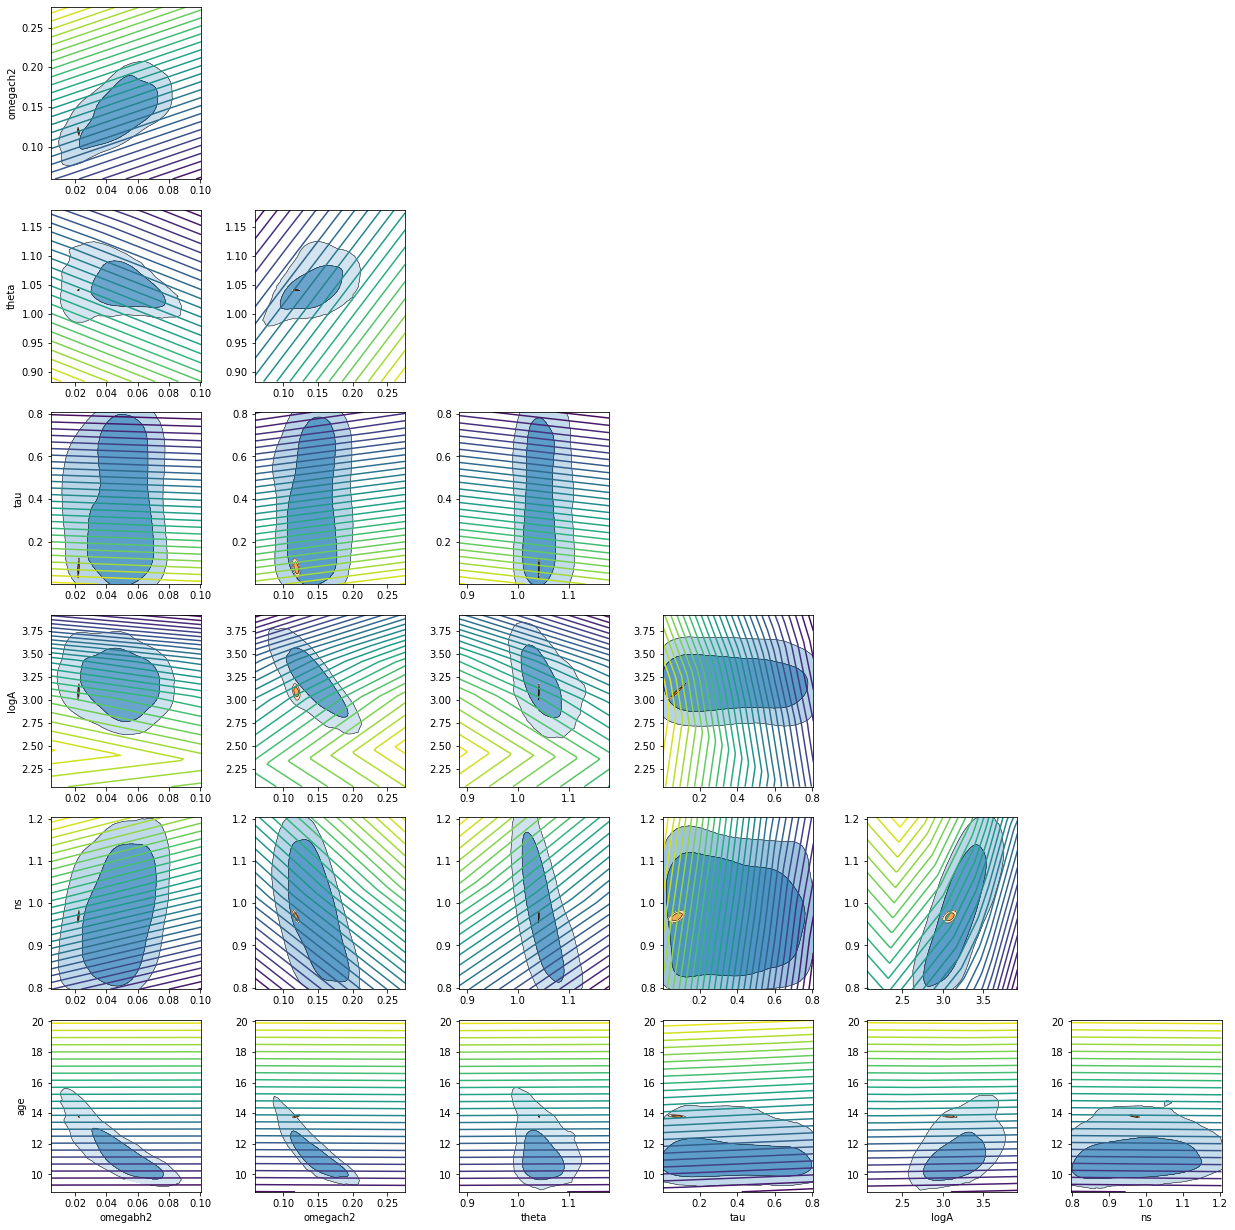

In [11]:
fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        if i > j:
            train_util_R.visualise_coordinate(axs[i, j], idxs=(j, i))
            axs[i, j].set_title("")

            if j == 0:
                axs[i, j].set_ylabel(params[i])
            if i == 6:
                axs[i, j].set_xlabel(params[j])
            # axs[i, j].set_xlabel(j)
            # axs[i, j].set_ylabel(i)
        else:
            fig.delaxes(axs[i, j])
fig.tight_layout()